In [1]:
import multiprocessing
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import Aer, execute
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [2]:
system_size = 10
subsystem_size = 3
num_ones = system_size // 2

num_dim = 2 ** num_ones
# num_dim = 1
# for i in range(subsystem_size):
#     num_dim *= system_size - i
#     num_dim //= i + 1

seed_rng = default_rng()

In [3]:
def forward(circ, pairs, rng):
    for ip, (q0, q1) in enumerate(pairs):
        theta = np.arccos(rng.uniform(-1., 1.))
        lamb = rng.uniform(0., 2. * np.pi)
        phi = rng.uniform(0., 2. * np.pi)
        circ.u(theta, phi, lamb, q0)
        circ.x(q1)
        circ.cx(q0, q1)

    for _ in range(2 * num_dim - 2 - 3 * pairs.shape[0]):
        ip = rng.integers(pairs.shape[0])
        q0 = pairs[ip, 0]

        q1pool = np.append(pairs[:ip, 1], pairs[ip + 1:, 1])
        q1 = rng.choice(q1pool)
        #circ.swap(q0, q1)

        phi = rng.uniform(0., 2. * np.pi)
        circ.crz(phi, q0, q1)
        
def backward(circ, pairs, rng):
    for _ in range(2 * num_dim - 2 - 3 * pairs.shape[0]):
        ip = rng.integers(pairs.shape[0])
        q0 = pairs[ip, 0]

        q1pool = np.append(pairs[:ip, 1], pairs[ip + 1:, 1])
        q1 = rng.choice(q1pool)
        #circ.swap(q0, q1)

        phi = rng.uniform(0., 2. * np.pi)
        circ.crz(phi, q0, q1)

    for ip, (q0, q1) in enumerate(pairs):
        theta = np.arccos(rng.uniform(-1., 1.))
        lamb = rng.uniform(0., 2. * np.pi)
        phi = rng.uniform(0., 2. * np.pi)
        circ.cx(q0, q1)
        circ.x(q1)
        circ.u(theta, phi, lamb, q0)

In [4]:
def print_statevector(statevector):
    probs = np.square(np.abs(statevector.reshape(-1)))
    for idx, prob in enumerate(probs):
        if prob < 1.e-9:
            continue
            
        bitstring = np.binary_repr(idx, width=system_size)
        z = np.char.count(bitstring, '1')
        print(idx, bitstring, int(bitstring, 2), z, prob)

In [5]:
def autofidelity(seed):
    rng = default_rng(seed=seed)
    arr = np.arange(system_size)
    rng.shuffle(arr)
    pairs = arr.reshape((-1, 2))

    qr_subsystem = QuantumRegister(subsystem_size, 'subsystem')
    qr_environment = QuantumRegister(system_size - subsystem_size, 'environment')
    cr_subsystem = ClassicalRegister(subsystem_size)
    cr_environment = ClassicalRegister(system_size - subsystem_size)

    circ = QuantumCircuit(qr_subsystem, qr_environment, cr_subsystem, cr_environment)
    forward(circ, pairs, rng)
    backward(circ, pairs, rng)
    
    backend = Aer.get_backend('statevector_simulator')

    job = execute(circ, backend)
    result = job.result()
    statevector = result.data()['statevector']
    return np.square(np.abs(statevector[0]))

num_exp = 1000
seeds = seed_rng.integers(2**16, size=num_exp)

with multiprocessing.Pool(32) as pool:
    fidelities = np.array(pool.map(autofidelity, seeds))

num_exp = 1000
fidelities = np.empty(num_exp, dtype=np.float)
num_dim = 2

backend = Aer.get_backend('statevector_simulator')

for iexp in range(num_exp):
    circ = QuantumCircuit(1, 1)
    
    theta = np.arccos(rng.uniform(-1., 1.))
    lamb = rng.uniform(0., 2. * np.pi)
    phi = rng.uniform(0., 2. * np.pi)
    circ.u(theta, phi, lamb, 0)
    
    theta = np.arccos(rng.uniform(-1., 1.))
    lamb = rng.uniform(0., 2. * np.pi)
    phi = rng.uniform(0., 2. * np.pi)
    circ.u(theta, phi, lamb, 0)    

    job = execute(circ, backend)
    result = job.result()
    statevector = result.data()['statevector']
    fidelities[iexp] = np.square(np.abs(statevector[0]))

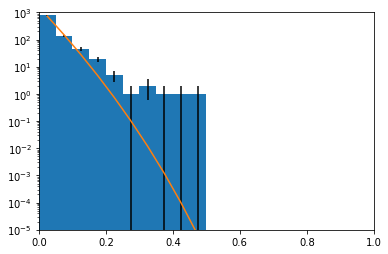

In [6]:
num_bins = 20

bins = np.linspace(0., 1., num_bins + 1)
binw = 1. / num_bins
bincenters = bins[:-1] + 0.5 * binw
hist_contents, _ = np.histogram(fidelities, bins=bins)

plt.bar(bincenters, hist_contents, width=binw, yerr=np.sqrt(hist_contents))

yref = fidelities.shape[0] * binw * (num_dim - 1) * np.power(1. - bincenters, num_dim - 2.)
plt.plot(bincenters, yref)

plt.xlim(0., 1.)
plt.ylim(1.e-5, fidelities.shape[0])
plt.yscale('log')

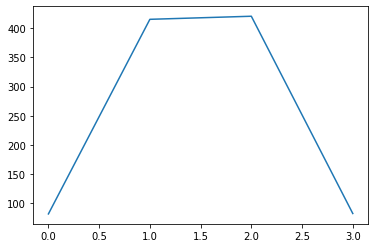

In [7]:
def zdist(seed):
    rng = default_rng(seed=seed)
    arr = np.arange(system_size)
    rng.shuffle(arr)
    pairs = arr.reshape((-1, 2))

    qr_subsystem = QuantumRegister(subsystem_size, 'subsystem')
    qr_environment = QuantumRegister(system_size - subsystem_size, 'environment')
    cr_subsystem = ClassicalRegister(subsystem_size)
    cr_environment = ClassicalRegister(system_size - subsystem_size)

    circ = QuantumCircuit(qr_subsystem, qr_environment, cr_subsystem, cr_environment)
    forward(circ, pairs, rng)
    
    backend = Aer.get_backend('statevector_simulator')

    job = execute(circ, backend)
    result = job.result()
    statevector = result.data()['statevector'].reshape((-1, 2 ** subsystem_size))
    probs = np.sum(np.square(np.abs(statevector)), axis=0)
    
    result = np.zeros(subsystem_size + 1, dtype=np.float)
    for idx, prob in enumerate(probs):
        z = np.sum(np.unpackbits(np.array(idx, dtype=np.uint8)))
        result[z] += prob

    return result

num_exp = 1000
seeds = seed_rng.integers(2**16, size=num_exp)

with multiprocessing.Pool(32) as pool:
    distribution = sum(pool.map(zdist, seeds))

plt.plot(np.arange(subsystem_size + 1), distribution)